<a href="https://colab.research.google.com/github/skbetz54/Samuel_DATA606/blob/main/Notebooks/2_1_Machine_Learning_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Implementation

Now that our data from huggingface has been cleaned and preprocessed [here](https://colab.research.google.com/drive/1Zf6250GENm1EVOdGW35kDIj8AaDKQcbz?authuser=1#scrollTo=yf5hmBqViYX1&uniqifier=1), we can now begin to work on our sentiment classifier, which will in turn be used to predict the level of fear being used within 

In [ ]:
"""
The below code is pulling publicly available code from UMBC adjunct professor Edward Raff. 
These notebooks include functions that aid in the training and testing of various deep learning models,
some of which I will be using within this code (with brief explanations of the functions as they appear).

"""

!git clone https://github.com/EdwardRaff/Inside-Deep-Learning.git
%run /content/Inside-Deep-Learning/idlmam.py

fatal: destination path 'Inside-Deep-Learning' already exists and is not an empty directory.


<Figure size 432x288 with 0 Axes>

In [ ]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
# Necessary Notebook Imports

from google.colab import files, drive

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader

import time
import tqdm
from itertools import islice

In [ ]:
# Mounting my google drive to upload the necessary csv file from part 1.1

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Initial CSV Import

The following CSV is being imported from [the project's first notebook](https://colab.research.google.com/drive/1Zf6250GENm1EVOdGW35kDIj8AaDKQcbz?authuser=1#scrollTo=6MWKFpPmTqw8&uniqifier=1). However, one more step has to be completed.


In [ ]:
# Opening the cleaned CSV of huggingface data to be used.

path = "/content/gdrive/MyDrive/DATA606/Data/output_cleaned.csv"

df = pd.read_csv(path)
df.drop(columns = 'Unnamed: 0', inplace = True)
df.head()

,text,emotions,class,pos_or_neg,tokenized_text,no_stopwords,part_of_speech,wn_part_of_speech,lemmatized,lemma_string,sentiment
0,i feel awful about it too because it s my job ...,sadness,2,negative,"['i', 'feel', 'awful', 'about', 'it', 'too', '...","['feel', 'awful', 'job', 'get', 'position', 's...","[('feel', 'VB'), ('awful', 'JJ'), ('job', 'NN'...","[('feel', 'v'), ('awful', 'a'), ('job', 'n'), ...","['feel', 'awful', 'job', 'get', 'position', 's...",feel awful job get position succeed happen,-1.000000
1,im alone i feel awful,sadness,2,negative,"['im', 'alone', 'i', 'feel', 'awful']","['alone', 'feel', 'awful']","[('alone', 'RB'), ('feel', 'NN'), ('awful', 'J...","[('alone', 'r'), ('feel', 'n'), ('awful', 'a')]","['alone', 'feel', 'awful']",alone feel awful,-1.000000
2,ive probably mentioned this before but i reall...,joy,3,positive,"['ive', 'probably', 'mentioned', 'this', 'befo...","['probably', 'mentioned', 'really', 'feel', 'p...","[('probably', 'RB'), ('mentioned', 'VBN'), ('r...","[('probably', 'r'), ('mentioned', 'v'), ('real...","['probably', 'mention', 'really', 'feel', 'pro...",probably mention really feel proud actually ke...,0.284091
3,i was feeling a little low few days back,sadness,2,negative,"['i', 'was', 'feeling', 'a', 'little', 'low', ...","['feeling', 'little', 'low', 'days', 'back']","[('feeling', 'VBG'), ('little', 'JJ'), ('low',...","[('feeling', 'v'), ('little', 'a'), ('low', 'a...","['feel', 'little', 'low', 'day', 'back']",feel little low day back,-0.062500
4,i beleive that i am much more sensitive to oth...,love,4,positive,"['i', 'beleive', 'that', 'i', 'am', 'much', 'm...","['beleive', 'much', 'sensitive', 'peoples', 'f...","[('beleive', 'JJ'), ('much', 'RB'), ('sensitiv...","[('beleive', 'a'), ('much', 'r'), ('sensitive'...","['beleive', 'much', 'sensitive', 'people', 'fe...",beleive much sensitive people feeling tend com...,0.100000


In [ ]:
print(df.shape)
df.emotions.value_counts()

(416809, 11)


joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: emotions, dtype: int64

## Downsampling data

As mentioned in the previous notebooks and shown above, the emotions of joy and sadness have many more samples than other emotions. This can have a negative impact on the sentiment classification model, as the large classes will overwhelm the classes with a smaller number of samples. The model will be able to obtain a decent accuracy while only guessing joy and sadness, giving us the impression that the model is effective.

For this reason I am going to downsample these larger classes to create a more balanced dataset. Using pandas tools to randomly delete rows I will end up with joy and sadness classes of 50,000 samples each.

To do this, I'll create separate dataframes for each class, delete random samples for both sadness and joy, concatenate the dataframes and shuffle the remaining samples.

In [ ]:
df_fear = df[df['class']==0]
df_fear.reset_index(inplace = True) #resetting index
df_anger = df[df['class']==1]
df_anger.reset_index(inplace = True) #resetting index
df_sadness = df[df['class']==2]
df_sadness.reset_index(inplace = True) #resetting index
df_joy = df[df['class']==3]
df_joy.reset_index(inplace = True) #resetting index
df_love = df[df['class']==4]
df_love.reset_index(inplace = True) #resetting index
df_surprise = df[df['class']==5]
df_surprise.reset_index(inplace = True)

In [ ]:
# Code for deleting rows in joy dataset

np.random.seed(5) #randomizing the number of rows to be dropped

remove_n = 91067 # to get 50,000 entries for joy, I need to delete 91,067 rows from the joy 

drop_indices = np.random.choice(df_joy.index, remove_n, replace=False)
df_joy_subset = df_joy.drop(drop_indices)

In [ ]:
# Code for deleting rows in sadness dataset

np.random.seed(18) #randomizing the number of rows to be dropped

remove_n = 71187 # to get 50,000 entries for sadness, I need to delete 71,187 rows from the sadness dataframe

drop_indices = np.random.choice(df_sadness.index, remove_n, replace=False)
df_sadness_subset = df_sadness.drop(drop_indices)

In [ ]:
# Sanity check to ensure there are now 50,000 entries for both sadness and joy

print("Joy\n"+str(df_joy_subset.shape)+"\nSadness:\n" + str(df_sadness_subset.shape))

Joy
(50000, 12)
Sadness:
(50000, 12)


In [ ]:
# Now that our larger classes have been downsampled, we can concatenate the dataframes back together into a single dataframe.

df_subset = pd.concat([df_fear, df_anger, df_sadness_subset, df_love, df_surprise, df_joy_subset], axis=0)

In [ ]:
print(df_subset.shape)

(254555, 12)


In [ ]:
# Shuffling dataset and resetting index
# df_subset.drop(columns = 'index', inplace=True)

df_subset = shuffle(df_subset)

df_subset.head()

,index,text,emotions,class,pos_or_neg,tokenized_text,no_stopwords,part_of_speech,wn_part_of_speech,lemmatized,lemma_string,sentiment
21660,156928,im feeling slightly agitated,anger,1,negative,"['im', 'feeling', 'slightly', 'agitated']","['feeling', 'slightly', 'agitated']","[('feeling', 'VBG'), ('slightly', 'RB'), ('agi...","[('feeling', 'v'), ('slightly', 'r'), ('agitat...","['feel', 'slightly', 'agitate']",feel slightly agitate,-0.166667
2444,66387,i am happy to report that my feeling of wantin...,surprise,5,positive,"['i', 'am', 'happy', 'to', 'report', 'that', '...","['happy', 'report', 'feeling', 'wanting', 'vie...","[('happy', 'JJ'), ('report', 'NN'), ('feeling'...","[('happy', 'a'), ('report', 'n'), ('feeling', ...","['happy', 'report', 'feel', 'want', 'viewer', ...",happy report feel want viewer shock imagery ma...,0.800000
18103,219666,i feel he often gentle adds a little bit of su...,love,4,positive,"['i', 'feel', 'he', 'often', 'gentle', 'adds',...","['feel', 'often', 'gentle', 'adds', 'little', ...","[('feel', 'NN'), ('often', 'RB'), ('gentle', '...","[('feel', 'n'), ('often', 'r'), ('gentle', 'a'...","['feel', 'often', 'gentle', 'add', 'little', '...",feel often gentle add little bit summary book go,0.006250
55193,401566,i dont feel like doing that again because mama...,anger,1,negative,"['i', 'dont', 'feel', 'like', 'doing', 'that',...","['feel', 'like', 'mama', 'rabbit', 'got', 'rea...","[('feel', 'NN'), ('like', 'IN'), ('mama', 'NN'...","[('feel', 'n'), ('like', 'n'), ('mama', 'n'), ...","['feel', 'like', 'mama', 'rabbit', 'get', 'rea...",feel like mama rabbit get really ferocious sta...,0.200000
35842,106377,i feel comfortable and like i don t have to pr...,joy,3,positive,"['i', 'feel', 'comfortable', 'and', 'like', 'i...","['feel', 'comfortable', 'like', 'pretend', 'an...","[('feel', 'NN'), ('comfortable', 'JJ'), ('like...","[('feel', 'n'), ('comfortable', 'a'), ('like',...","['feel', 'comfortable', 'like', 'pretend', 'an...",feel comfortable like pretend anything,0.400000


In [ ]:
save_path = "/content/gdrive/MyDrive/DATA606/Data/output_subset.csv"

with open(save_path, 'w', encoding = 'utf-8-sig') as f:
  df_subset.to_csv(f)

In [ ]:
# len(df['lemmatized'][0].tolist())

# df['word_length'] = [len(l.split(sep=" ")) for l in df['lemma_string']]

df['word_length'] = df['lemma_string'].apply(lambda row: len(str(row).split(sep = " ")))

df.head()

# type(df['lemma_string'][0])

,index,text,emotions,class,pos_or_neg,tokenized_text,no_stopwords,part_of_speech,wn_part_of_speech,lemmatized,lemma_string,sentiment,word_length
0,156928,im feeling slightly agitated,anger,1,negative,"['im', 'feeling', 'slightly', 'agitated']","['feeling', 'slightly', 'agitated']","[('feeling', 'VBG'), ('slightly', 'RB'), ('agi...","[('feeling', 'v'), ('slightly', 'r'), ('agitat...","['feel', 'slightly', 'agitate']",feel slightly agitate,-0.166667,3
1,66387,i am happy to report that my feeling of wantin...,surprise,5,positive,"['i', 'am', 'happy', 'to', 'report', 'that', '...","['happy', 'report', 'feeling', 'wanting', 'vie...","[('happy', 'JJ'), ('report', 'NN'), ('feeling'...","[('happy', 'a'), ('report', 'n'), ('feeling', ...","['happy', 'report', 'feel', 'want', 'viewer', ...",happy report feel want viewer shock imagery ma...,0.800000,10
2,219666,i feel he often gentle adds a little bit of su...,love,4,positive,"['i', 'feel', 'he', 'often', 'gentle', 'adds',...","['feel', 'often', 'gentle', 'adds', 'little', ...","[('feel', 'NN'), ('often', 'RB'), ('gentle', '...","[('feel', 'n'), ('often', 'r'), ('gentle', 'a'...","['feel', 'often', 'gentle', 'add', 'little', '...",feel often gentle add little bit summary book go,0.006250,9
3,401566,i dont feel like doing that again because mama...,anger,1,negative,"['i', 'dont', 'feel', 'like', 'doing', 'that',...","['feel', 'like', 'mama', 'rabbit', 'got', 'rea...","[('feel', 'NN'), ('like', 'IN'), ('mama', 'NN'...","[('feel', 'n'), ('like', 'n'), ('mama', 'n'), ...","['feel', 'like', 'mama', 'rabbit', 'get', 'rea...",feel like mama rabbit get really ferocious sta...,0.200000,12
4,106377,i feel comfortable and like i don t have to pr...,joy,3,positive,"['i', 'feel', 'comfortable', 'and', 'like', 'i...","['feel', 'comfortable', 'like', 'pretend', 'an...","[('feel', 'NN'), ('comfortable', 'JJ'), ('like...","[('feel', 'n'), ('comfortable', 'a'), ('like',...","['feel', 'comfortable', 'like', 'pretend', 'an...",feel comfortable like pretend anything,0.400000,5


# Data Loading

In [ ]:
df.drop(columns = 'index', inplace = True)

df.head()

,text,emotions,class,pos_or_neg,tokenized_text,no_stopwords,part_of_speech,wn_part_of_speech,lemmatized,lemma_string,sentiment,word_length
0,i mean like we always keep fighting and stuff ...,anger,1,negative,"['i', 'mean', 'like', 'we', 'always', 'keep', ...","['mean', 'like', 'always', 'keep', 'fighting',...","[('mean', 'NN'), ('like', 'IN'), ('always', 'R...","[('mean', 'n'), ('like', 'n'), ('always', 'r')...","['mean', 'like', 'always', 'keep', 'fight', 's...",mean like always keep fight stuff time doesnt ...,-0.356250,11
1,i looked up at her feeling slightly dazed,surprise,5,positive,"['i', 'looked', 'up', 'at', 'her', 'feeling', ...","['looked', 'feeling', 'slightly', 'dazed']","[('looked', 'VBD'), ('feeling', 'VBG'), ('slig...","[('looked', 'v'), ('feeling', 'v'), ('slightly...","['look', 'feel', 'slightly', 'daze']",look feel slightly daze,-0.166667,4
2,is music just feels lovely and innocent to me,love,4,positive,"['is', 'music', 'just', 'feels', 'lovely', 'an...","['music', 'feels', 'lovely', 'innocent']","[('music', 'NN'), ('feels', 'NNS'), ('lovely',...","[('music', 'n'), ('feels', 'n'), ('lovely', 'r...","['music', 'feel', 'lovely', 'innocent']",music feel lovely innocent,0.500000,4
3,i went to visit a friend in hospital he was go...,fear,0,negative,"['i', 'went', 'to', 'visit', 'a', 'friend', 'i...","['went', 'visit', 'friend', 'hospital', 'going...","[('went', 'VBD'), ('visit', 'NN'), ('friend', ...","[('went', 'v'), ('visit', 'n'), ('friend', 'n'...","['go', 'visit', 'friend', 'hospital', 'go', 'o...",go visit friend hospital go operated next day ...,-0.300000,15
4,i feel asleep but i was restless and it wasn t...,fear,0,negative,"['i', 'feel', 'asleep', 'but', 'i', 'was', 're...","['feel', 'asleep', 'restless', 'every', 'worth...","[('feel', 'VB'), ('asleep', 'JJ'), ('restless'...","[('feel', 'v'), ('asleep', 'a'), ('restless', ...","['feel', 'asleep', 'restless', 'every', 'worth...",feel asleep restless every worth call rest,0.300000,7


In [ ]:
save_path = "/content/gdrive/MyDrive/DATA606/Data/output_cleaned_15k.csv"


df = pd.read_csv(save_path)
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,index,text,emotions,class,pos_or_neg,tokenized_text,no_stopwords,part_of_speech,wn_part_of_speech,lemmatized,lemma_string,sentiment,word_length
0,187712,i mean like we always keep fighting and stuff ...,anger,1,negative,"['i', 'mean', 'like', 'we', 'always', 'keep', ...","['mean', 'like', 'always', 'keep', 'fighting',...","[('mean', 'NN'), ('like', 'IN'), ('always', 'R...","[('mean', 'n'), ('like', 'n'), ('always', 'r')...","['mean', 'like', 'always', 'keep', 'fight', 's...",mean like always keep fight stuff time doesnt ...,-0.356250,11
1,387664,i looked up at her feeling slightly dazed,surprise,5,positive,"['i', 'looked', 'up', 'at', 'her', 'feeling', ...","['looked', 'feeling', 'slightly', 'dazed']","[('looked', 'VBD'), ('feeling', 'VBG'), ('slig...","[('looked', 'v'), ('feeling', 'v'), ('slightly...","['look', 'feel', 'slightly', 'daze']",look feel slightly daze,-0.166667,4
2,214648,is music just feels lovely and innocent to me,love,4,positive,"['is', 'music', 'just', 'feels', 'lovely', 'an...","['music', 'feels', 'lovely', 'innocent']","[('music', 'NN'), ('feels', 'NNS'), ('lovely',...","[('music', 'n'), ('feels', 'n'), ('lovely', 'r...","['music', 'feel', 'lovely', 'innocent']",music feel lovely innocent,0.500000,4
3,311351,i went to visit a friend in hospital he was go...,fear,0,negative,"['i', 'went', 'to', 'visit', 'a', 'friend', 'i...","['went', 'visit', 'friend', 'hospital', 'going...","[('went', 'VBD'), ('visit', 'NN'), ('friend', ...","[('went', 'v'), ('visit', 'n'), ('friend', 'n'...","['go', 'visit', 'friend', 'hospital', 'go', 'o...",go visit friend hospital go operated next day ...,-0.300000,15
4,59577,i feel asleep but i was restless and it wasn t...,fear,0,negative,"['i', 'feel', 'asleep', 'but', 'i', 'was', 're...","['feel', 'asleep', 'restless', 'every', 'worth...","[('feel', 'VB'), ('asleep', 'JJ'), ('restless'...","[('feel', 'v'), ('asleep', 'a'), ('restless', ...","['feel', 'asleep', 'restless', 'every', 'worth...",feel asleep restless every worth call rest,0.300000,7


In [ ]:
max(df['word_length'])

45

In [ ]:
# Dictionary Creation
"""
-----------------------

-----------------------
"""

t1 = time.perf_counter()

tweet_dict = {key: value["lemma_string"].tolist() for key, value in df.groupby("emotions")}

t2 = time.perf_counter()

print("Time to create tweet dictionary: "+ str(t2-t1) +" seconds")
print("Dictionary length (number of unique emotions): " + str(len(tweet_dict)))
print("Number of items per emotion:")
for key, value in tweet_dict.items():
  print(key, len([item for item in value if item]))

Time to create tweet dictionary: 0.042311444000006304 seconds
Dictionary length (number of unique emotions): 6
Number of items per emotion:
anger 15000
fear 15000
joy 15000
love 15000
sadness 15000
surprise 14972


## COME BACK TO THIS AND TRY TO MAKE IT FASTER

In [ ]:
# Vocabulary Creation (Slow Version)
"""
-----------------------



-----------------------
"""

combined = df.lemma_string.str.cat(sep = " ")

t1 = time.perf_counter()

idx2word = {0:'PAD',1:'SOS',2:'EOS'}

for word in combined.split():
  if word not in idx2word.values():
    idx2word[len(idx2word)] = word

t2 = time.perf_counter()

print("Time to create vocabulary: %f seconds" %(t2-t1))
print("Length of Vocabulary: %d" %(len(idx2word)))

# Creating the inverse of the above dictionary for the purpose of output formatting

word2idx = {v: k for k, v in idx2word.items()}

Time to create vocabulary: 45.138996 seconds
Length of Vocabulary: 30000


In [ ]:
# Emotion Dataset without using Vocabulary Class

class EmotionDataset(Dataset):
  
  def __init__(self, dictionary, vocabulary):
    self.label_names = [name for name in dictionary.keys()]
    self.data = []
    self.labels = []
    self.vocabulary = vocabulary
    self.dictionary = dictionary
    self.max = 0

    for idx, emotion in enumerate(self.label_names):
      for sentence in dictionary[emotion]:
        self.data.append(sentence)
        self.labels.append(idx)
        # length = len(str(sentence).split())
        # if length > self.max:
        #   self.max = length
        # else:
        #   continue
      


    # for i, j in enumerate(dictionary.items()):
    #   data.append(str(j[0]).split(sep=" "))
    #   labels.append(j[1])

  def __len__(self):
    return len(self.data)


  def list2InputVec(self, input_list):
    """
    This method is going to take an input list (a.k.a the individual words within the sentence)
    and return a pytorch vector of long integers, where each integer represents the index within the assigned
    vocabulary. 
    """
    # T = len(input_list.split(sep = " "))

    # T = 45
    T = len(str(input_list).split(sep = " "))

    sentence_vect = torch.zeros((T), dtype=torch.long) 

    for position, vector in enumerate(str(input_list).split(sep=" ")):
      sentence_vect[position] = word2idx[vector]

    return sentence_vect

  def __getitem__(self, index):
    name = self.data[index]
    label = self.labels[index]
    
    # label_vector = torch.tensor([label], dtype = torch.long)                                

    return self.list2InputVec(name), label

In [ ]:
emo_dataset = EmotionDataset(dictionary=tweet_dict, vocabulary = idx2word)

print(len(emo_dataset))

print(emo_dataset[0])

89972
(tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 0)


In [ ]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(list(range(len(emo_dataset.labels))), test_size = .2, stratify = emo_dataset.labels)

train_data = torch.utils.data.Subset(emo_dataset, train_idx)
test_data = torch.utils.data.Subset(emo_dataset, test_idx)

In [ ]:
print(len(train_data))
print(len(test_data))

71977
17995


In [ ]:
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Model 1: Standard RNN

The first model is going to be a simple multilayer RNN

In [ ]:
D = 64
vocab_size = len(word2idx)
hidden_nodes = 256
classes = len(tweet_dict.keys())

lossfunc = nn.CrossEntropyLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
RNN_standard = nn.Sequential(
    nn.Embedding(vocab_size, D),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)


RNN_packed = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

RNN_packed.to(device)

RuntimeError: ignored

In [ ]:
len(idx2word)

30000

In [ ]:
lossfunc = nn.CrossEntropyLoss()


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

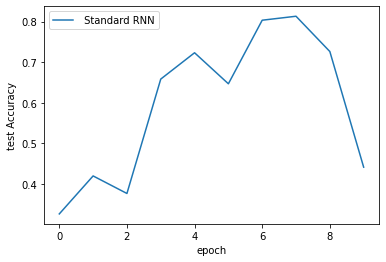

In [ ]:
batch_one_train = train_simple_network(RNN_standard, lossfunc, train_loader,
test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=10)
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train, label='Standard RNN')

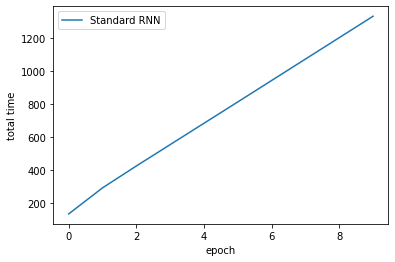

In [ ]:
sns.lineplot(x='epoch', y='total time', data=batch_one_train, label = 'Standard RNN')

In [ ]:
batch_one_train.head()

,epoch,total time,train loss,test loss,train Accuracy,test Accuracy
0,0,131.826719,1.709639,1.663654,0.284494,0.325813
1,1,290.190338,1.609806,1.473087,0.357892,0.419450
2,2,423.324630,1.373091,1.612969,0.473582,0.376216
3,3,553.364570,1.166171,0.974916,0.571835,0.658183
4,4,683.289360,0.878551,0.803499,0.696736,0.723090


In [ ]:
batch_one_train['name'] = 'Standard RNN 1 Batch'

batch_one_train.head()

,epoch,total time,train loss,test loss,train Accuracy,test Accuracy,name
0,0,131.826719,1.709639,1.663654,0.284494,0.325813,Standard RNN 1 Batch
1,1,290.190338,1.609806,1.473087,0.357892,0.419450,Standard RNN 1 Batch
2,2,423.324630,1.373091,1.612969,0.473582,0.376216,Standard RNN 1 Batch
3,3,553.364570,1.166171,0.974916,0.571835,0.658183,Standard RNN 1 Batch
4,4,683.289360,0.878551,0.803499,0.696736,0.723090,Standard RNN 1 Batch


In [ ]:
save_path = "/content/gdrive/MyDrive/DATA606/Data/results_subset_1.csv"

with open(save_path, 'w', encoding = 'utf-8-sig') as f:
  batch_one_train.to_csv(f)

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn = pad_and_pack)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn = pad_and_pack)

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

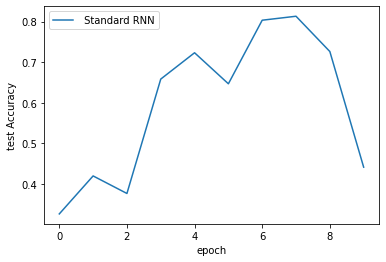

In [ ]:
batch_packed_train = train_simple_network(RNN_packed, lossfunc, train_loader,
test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=25)
sns.lineplot(x='epoch', y='test Accuracy', data=batch_packed_train, label='Packed RNN')

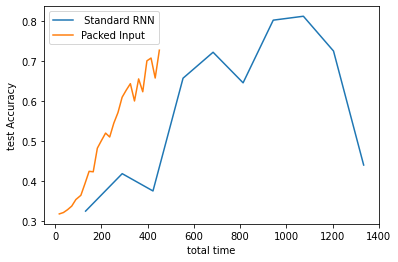

In [ ]:
sns.lineplot(x='total time', y='test Accuracy', data=batch_one_train, label=' Standard RNN')
sns.lineplot(x='total time', y='test Accuracy', data=batch_packed_train, label='Packed Input')

In [ ]:
batch_one_train['name'] = 'Standard RNN 1 Batch - 15k'
batch_one_train['num_samples'] = '15k'
batch_packed_train['name'] = 'Standard RNN Packed Batch - 15k'
batch_packed_train['num_samples'] = '15k'

In [ ]:
results_1 = pd.concat([batch_one_train, batch_packed_train], axis = 0)

In [ ]:
save_path = "/content/gdrive/MyDrive/DATA606/Data/results_subset_2.csv"

with open(save_path, 'w', encoding = 'utf-8-sig') as f:
  batch_one_train.to_csv(f)

## 50 K Subset



In [ ]:
save_path = "/content/gdrive/MyDrive/DATA606/Data/output_cleaned_50k.csv"


df = pd.read_csv(save_path)
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,index,text,emotions,class,pos_or_neg,tokenized_text,no_stopwords,part_of_speech,wn_part_of_speech,lemmatized,lemma_string,sentiment,word_length
0,156928,im feeling slightly agitated,anger,1,negative,"['im', 'feeling', 'slightly', 'agitated']","['feeling', 'slightly', 'agitated']","[('feeling', 'VBG'), ('slightly', 'RB'), ('agi...","[('feeling', 'v'), ('slightly', 'r'), ('agitat...","['feel', 'slightly', 'agitate']",feel slightly agitate,-0.166667,3
1,66387,i am happy to report that my feeling of wantin...,surprise,5,positive,"['i', 'am', 'happy', 'to', 'report', 'that', '...","['happy', 'report', 'feeling', 'wanting', 'vie...","[('happy', 'JJ'), ('report', 'NN'), ('feeling'...","[('happy', 'a'), ('report', 'n'), ('feeling', ...","['happy', 'report', 'feel', 'want', 'viewer', ...",happy report feel want viewer shock imagery ma...,0.800000,10
2,219666,i feel he often gentle adds a little bit of su...,love,4,positive,"['i', 'feel', 'he', 'often', 'gentle', 'adds',...","['feel', 'often', 'gentle', 'adds', 'little', ...","[('feel', 'NN'), ('often', 'RB'), ('gentle', '...","[('feel', 'n'), ('often', 'r'), ('gentle', 'a'...","['feel', 'often', 'gentle', 'add', 'little', '...",feel often gentle add little bit summary book go,0.006250,9
3,401566,i dont feel like doing that again because mama...,anger,1,negative,"['i', 'dont', 'feel', 'like', 'doing', 'that',...","['feel', 'like', 'mama', 'rabbit', 'got', 'rea...","[('feel', 'NN'), ('like', 'IN'), ('mama', 'NN'...","[('feel', 'n'), ('like', 'n'), ('mama', 'n'), ...","['feel', 'like', 'mama', 'rabbit', 'get', 'rea...",feel like mama rabbit get really ferocious sta...,0.200000,12
4,106377,i feel comfortable and like i don t have to pr...,joy,3,positive,"['i', 'feel', 'comfortable', 'and', 'like', 'i...","['feel', 'comfortable', 'like', 'pretend', 'an...","[('feel', 'NN'), ('comfortable', 'JJ'), ('like...","[('feel', 'n'), ('comfortable', 'a'), ('like',...","['feel', 'comfortable', 'like', 'pretend', 'an...",feel comfortable like pretend anything,0.400000,5


In [ ]:
# Dictionary Creation
"""
-----------------------

-----------------------
"""

t1 = time.perf_counter()

tweet_dict = {key: value["lemma_string"].tolist() for key, value in df.groupby("emotions")}

t2 = time.perf_counter()

print("Time to create tweet dictionary: "+ str(t2-t1) +" seconds")
print("Dictionary length (number of unique emotions): " + str(len(tweet_dict)))
print("Number of items per emotion:")
for key, value in tweet_dict.items():
  print(key, len([item for item in value if item]))

Time to create tweet dictionary: 0.11726758100121515 seconds
Dictionary length (number of unique emotions): 6
Number of items per emotion:
anger 57317
fear 47712
joy 50000
love 34554
sadness 50000
surprise 14972


In [ ]:
# Vocabulary Creation (Slow Version)
"""
-----------------------



-----------------------
"""

combined = df.lemma_string.str.cat(sep = " ")

t1 = time.perf_counter()

idx2word = {0:'PAD',1:'SOS',2:'EOS'}

for word in combined.split():
  if word not in idx2word.values():
    idx2word[len(idx2word)] = word

t2 = time.perf_counter()

print("Time to create vocabulary: %f seconds" %(t2-t1))
print("Length of Vocabulary: %d" %(len(idx2word)))

# Creating the inverse of the above dictionary for the purpose of output formatting

word2idx = {v: k for k, v in idx2word.items()}

Time to create vocabulary: 151.247022 seconds
Length of Vocabulary: 50877


In [ ]:
emo_dataset = EmotionDataset(dictionary=tweet_dict, vocabulary = idx2word)

from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(list(range(len(emo_dataset.labels))), test_size = .2, stratify = emo_dataset.labels)

train_data = torch.utils.data.Subset(emo_dataset, train_idx)
test_data = torch.utils.data.Subset(emo_dataset, test_idx)

In [ ]:
train_loader_1 = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader_1 = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
D = 64
vocab_size = len(word2idx)
hidden_nodes = 256
classes = len(tweet_dict.keys())

lossfunc = nn.CrossEntropyLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
RNN_standard = nn.Sequential(
    nn.Embedding(vocab_size, D),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)


RNN_packed = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

RNN_packed.to(device)

RuntimeError: ignored

In [ ]:
CUDA_LAUNCH_BLOCKING = 1

In [ ]:
train_loader_16 = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader_16 = DataLoader(test_data, batch_size=16, shuffle=False)

In [ ]:
batch_one_train = train_simple_network(RNN_standard, lossfunc, train_loader,
test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=10)
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train, label='Standard RNN')

In [ ]:
batch_packed_train = train_simple_network(RNN_packed, lossfunc, train_loader,
test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=25)
sns.lineplot(x='epoch', y='test Accuracy', data=batch_packed_train, label='Packed RNN')

RuntimeError: ignored

In [ ]:
# Vocabulary Creation (Faster?) Version
"""
-----------------------



-----------------------
"""

pad_token = 0 # token location for padding used in shorter sentences
sos_token = 1 # location for the token of the start of the sentence
eos_token = 2 # location for the token of the end of the sentence


vocab = {0:'PAD',1:'SOS',2:'EOS'}

combined = df.lemma_string.str.cat(sep)


class Vocab:

  pad_token = 0 # token location for padding used in shorter sentences
  sos_token = 1 # location for the token of the start of the sentence
  eos_token = 2 # location for the token of the end of the sentence

  def __init__(self, name, count_threshold):
    self.name = name
    self.count_threshold = count_threshold
    self.idx2word = {pad_token:"PAD",sos_token:"SOS",eos_token:"EOS"}
    self.word2idx = {}
    self.word2count = {}
    self.num_words = 3
    self.num_sentences = 0
    self.longest_sentence = 0

  def add_word(self, word):
    if word not in word2idx:
      self.word2idx[word] = self.num_words
      self.word2count = 1
      self.idx2word[self.num_words] = word
      self.num_words +=1
    else:
      self.word2count[word] +=1

  def add_row(self, sentence):
    sent_len = 0
    for 

SyntaxError: ignored